In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if "../../" not in sys.path:
    sys.path.append("../../")
    print("[sys.path]:", sys.path)

[sys.path]: ['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/nadir/MoLiNER/.venv/lib/python3.10/site-packages', '../../']


In [3]:
from src.data.babel import BabelDataset

/home/nadir/MoLiNER/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_dataset = BabelDataset(
    split="train",
    pipeline="babel"
)
validation_dataset = BabelDataset(
    split="validation",
    pipeline="babel"
)

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [5]:
print("[#train_dataset]:", len(train_dataset))
print("[#validation_dataset]:", len(validation_dataset))

[#train_dataset]: 6615
[#validation_dataset]: 2193


In [6]:
import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

from src.constants import (
    DEFAULT_FPS
)

In [7]:
plt.style.use('default')
sns.set_palette("husl")

In [8]:
def analyze_prompts(dataset, dataset_name="Dataset"):
    all_prompts = []
    sample_prompt_counts = []
    source_counts = Counter()
    is_sequence_counts = Counter()
    durations = []
    sequence_durations = []
    frame_durations = []
    spans_per_prompt = defaultdict(list)
    
    motion_lengths_frames = []
    motion_lengths_seconds = []
    spans_per_motion = []
    spans_durations_per_motion = []
    
    for i, sample in enumerate(tqdm.tqdm(dataset)):
        prompts_list = sample.get("prompts", [])
        sample_prompt_counts.append(len(prompts_list))
        
        motion = sample.get("motion", {})
        if isinstance(motion, dict) and "new_joint_vecs" in motion:
            motion_length = len(motion["new_joint_vecs"])
            motion_lengths_frames.append(motion_length)
            motion_lengths_seconds.append(motion_length / DEFAULT_FPS)
        
        motion_spans = []
        motion_spans_durations = []
        
        for prompt_data in prompts_list:
            prompt_text = prompt_data.get("text", "")
            span = prompt_data.get("span", [])
            source = prompt_data.get("source", "unknown")
            is_sequence = prompt_data.get("is_sequence", True)
            
            all_prompts.append(prompt_text)
            source_counts[source] += 1
            is_sequence_counts[is_sequence] += 1
            
            if len(span) == 2:
                duration_frames = span[1] - span[0]
                durations.append(duration_frames)
                spans_per_prompt[prompt_text].append(span)
                motion_spans.append(span)
                motion_spans_durations.append(duration_frames)
                
                if is_sequence:
                    sequence_durations.append(duration_frames)
                else:
                    frame_durations.append(duration_frames)
        
        spans_per_motion.append(len(motion_spans))
        spans_durations_per_motion.append(sum(motion_spans_durations) if motion_spans_durations else 0)
    
    return {
        'all_prompts': all_prompts,
        'sample_prompt_counts': sample_prompt_counts,
        'source_counts': source_counts,
        'is_sequence_counts': is_sequence_counts,
        'durations': durations,
        'sequence_durations': sequence_durations,
        'frame_durations': frame_durations,
        'spans_per_prompt': spans_per_prompt,
        'dataset_name': dataset_name,
        'motion_lengths_frames': motion_lengths_frames,
        'motion_lengths_seconds': motion_lengths_seconds,
        'spans_per_motion': spans_per_motion,
        'spans_durations_per_motion': spans_durations_per_motion
    }

In [9]:
train_analysis = analyze_prompts(train_dataset, "Train")
validation_analysis = analyze_prompts(validation_dataset, "Validation")

100%|██████████| 2193/2193 [02:01<00:00, 18.00it/s]


In [10]:
print("=== BASIC STATISTICS ===")
print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(validation_dataset)} samples")
print()

for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    print(f"{name} Dataset:")
    print(f"  Total prompts: {len(analysis['all_prompts'])}")
    print(f"  Unique prompts: {len(set(analysis['all_prompts']))}")
    print(f"  Avg prompts per sample: {np.mean(analysis['sample_prompt_counts']):.2f}")
    print(f"  Min prompts per sample: {np.min(analysis['sample_prompt_counts'])}")
    print(f"  Max prompts per sample: {np.max(analysis['sample_prompt_counts'])}")
    print()
    
    print(f"  Source distribution:")
    for source, count in analysis['source_counts'].items():
        print(f"    {source}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    print(f"  Sequence vs Frame annotations:")
    for is_seq, count in analysis['is_sequence_counts'].items():
        label = "Sequence" if is_seq else "Frame"
        print(f"    {label}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    if analysis['durations']:
        print(f"  Duration statistics (frames):")
        print(f"    Min: {np.min(analysis['durations'])} frames ({np.min(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Mean: {np.mean(analysis['durations']):.2f} frames ({np.mean(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Max: {np.max(analysis['durations'])} frames ({np.max(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Std: {np.std(analysis['durations']):.2f} frames ({np.std(analysis['durations'])/DEFAULT_FPS:.2f}s)")
    print("-" * 50)

=== BASIC STATISTICS ===
Train Dataset: 6615 samples
Validation Dataset: 2193 samples

Train Dataset:
  Total prompts: 143365
  Unique prompts: 9422
  Avg prompts per sample: 21.67
  Min prompts per sample: 3
  Max prompts per sample: 330

  Source distribution:
    proc_label: 43137 (30.1%)
    raw_label: 43137 (30.1%)
    act_cat: 57091 (39.8%)

  Sequence vs Frame annotations:
    Sequence: 22720 (15.8%)
    Frame: 120645 (84.2%)

  Duration statistics (frames):
    Min: -51 frames (-2.55s)
    Mean: 72.96 frames (3.65s)
    Max: 5271 frames (263.55s)
    Std: 164.16 frames (8.21s)
--------------------------------------------------
Validation Dataset:
  Total prompts: 52433
  Unique prompts: 4336
  Avg prompts per sample: 23.91
  Min prompts per sample: 3
  Max prompts per sample: 331

  Source distribution:
    proc_label: 15744 (30.0%)
    raw_label: 15744 (30.0%)
    act_cat: 20945 (39.9%)

  Sequence vs Frame annotations:
    Sequence: 7794 (14.9%)
    Frame: 44639 (85.1%)

  Du

<div class="alert alert-info">

#### **Number of Motions**

This shows the total number of motion sequences in each dataset split.

</div>

=== NUMBER OF MOTIONS ===
Train Dataset: 6615 motions
Validation Dataset: 2193 motions


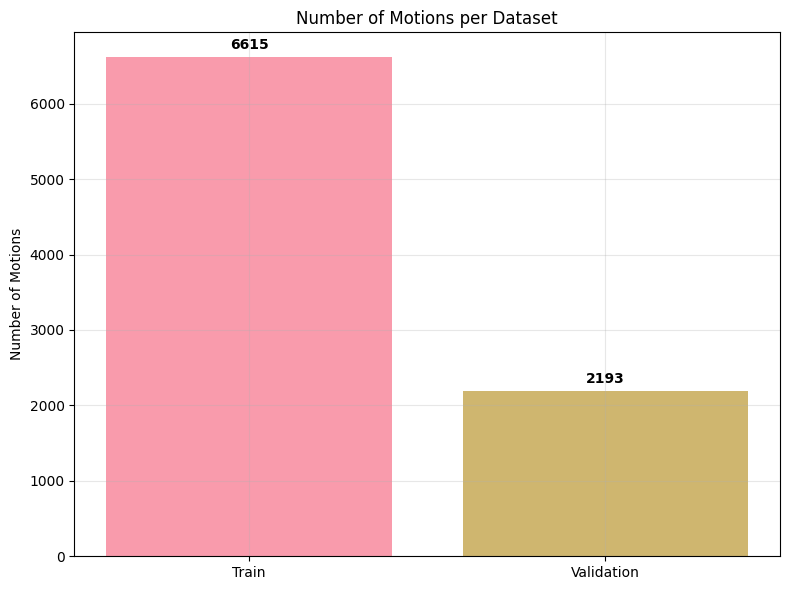

In [11]:
print("=== NUMBER OF MOTIONS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    num_motions = len(analysis['motion_lengths_frames'])
    print(f"{name} Dataset: {num_motions} motions")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
datasets = ['Train', 'Validation']
motion_counts = [len(train_analysis['motion_lengths_frames']), len(validation_analysis['motion_lengths_frames'])]
colors = ['C0', 'C1']

bars = ax.bar(datasets, motion_counts, color=colors, alpha=0.7)
ax.set_title('Number of Motions per Dataset')
ax.set_ylabel('Number of Motions')
ax.grid(True, alpha=0.3)

for bar, count in zip(bars, motion_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(motion_counts)*0.01, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Motion Length Distribution**

This shows the distribution of motion sequence lengths in both frames and seconds, with horizontal lines indicating minimum, maximum, and average values.

</div>

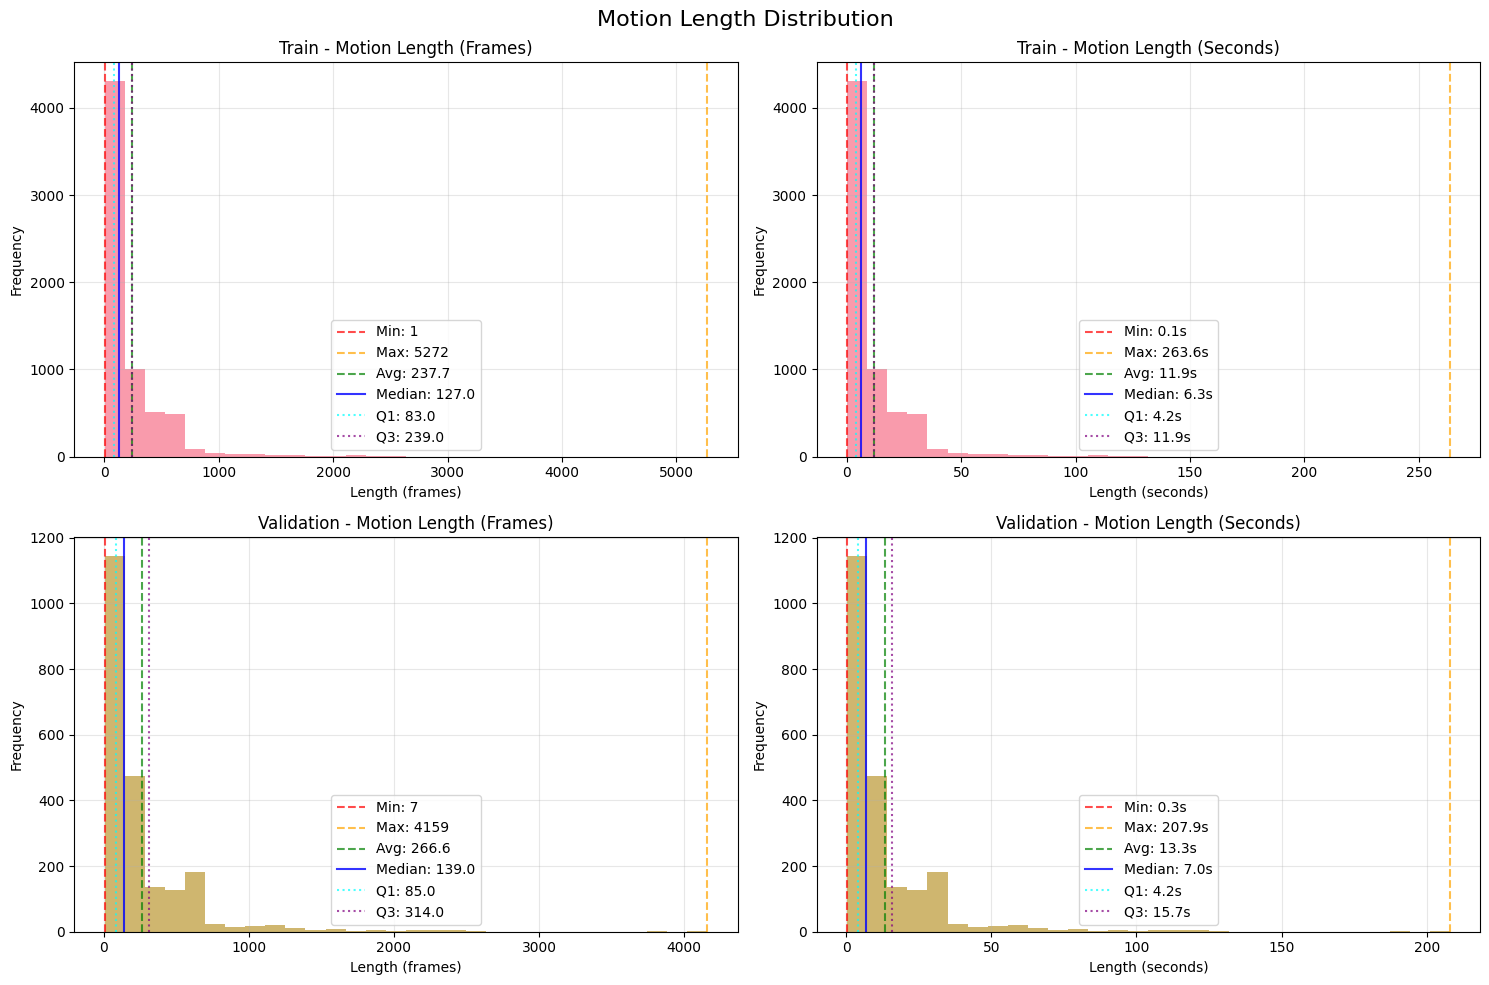

=== MOTION LENGTH STATISTICS ===

Train Dataset:
  Frames - Min: 1, Mean: 237.68, Max: 5272
  Seconds - Min: 0.05, Mean: 11.88, Max: 263.60
  75th percentile - Frames: 239.00, Seconds: 11.95
  Data loss if filtering > 10s (200 frames): 1972 samples (29.8%)
  Data loss if filtering > 15s (300 frames): 1441 samples (21.8%)
  Data loss if filtering > 20s (400 frames): 1155 samples (17.5%)
--------------------------------------------------

Validation Dataset:
  Frames - Min: 7, Mean: 266.62, Max: 4159
  Seconds - Min: 0.35, Mean: 13.33, Max: 207.95
  75th percentile - Frames: 314.00, Seconds: 15.70
  Data loss if filtering > 10s (200 frames): 739 samples (33.7%)
  Data loss if filtering > 15s (300 frames): 561 samples (25.6%)
  Data loss if filtering > 20s (400 frames): 462 samples (21.1%)
--------------------------------------------------


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Motion Length Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        # NOTE: frames distribution
        axes[i, 0].hist(lengths_frames, bins=30, alpha=0.7, color=f'C{i}')
        axes[i, 0].set_title(f'{name} - Motion Length (Frames)')
        axes[i, 0].set_xlabel('Length (frames)')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        min_frames = np.min(lengths_frames)
        max_frames = np.max(lengths_frames)
        avg_frames = np.mean(lengths_frames)
        median_frames = np.median(lengths_frames)
        q1_frames = np.percentile(lengths_frames, 25)
        q3_frames = np.percentile(lengths_frames, 75)
        
        axes[i, 0].axvline(min_frames, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_frames}')
        axes[i, 0].axvline(max_frames, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_frames}')
        axes[i, 0].axvline(avg_frames, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_frames:.1f}')
        axes[i, 0].axvline(median_frames, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_frames:.1f}')
        axes[i, 0].axvline(q1_frames, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_frames:.1f}')
        axes[i, 0].axvline(q3_frames, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_frames:.1f}')
        axes[i, 0].legend()
        
        # NOTE: seconds distribution
        axes[i, 1].hist(lengths_seconds, bins=30, alpha=0.7, color=f'C{i}')
        axes[i, 1].set_title(f'{name} - Motion Length (Seconds)')
        axes[i, 1].set_xlabel('Length (seconds)')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].grid(True, alpha=0.3)
        
        min_seconds = np.min(lengths_seconds)
        max_seconds = np.max(lengths_seconds)
        avg_seconds = np.mean(lengths_seconds)
        median_seconds = np.median(lengths_seconds)
        q1_seconds = np.percentile(lengths_seconds, 25)
        q3_seconds = np.percentile(lengths_seconds, 75)
        
        axes[i, 1].axvline(min_seconds, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_seconds:.1f}s')
        axes[i, 1].axvline(max_seconds, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_seconds:.1f}s')
        axes[i, 1].axvline(avg_seconds, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_seconds:.1f}s')
        axes[i, 1].axvline(median_seconds, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_seconds:.1f}s')
        axes[i, 1].axvline(q1_seconds, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_seconds:.1f}s')
        axes[i, 1].axvline(q3_seconds, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_seconds:.1f}s')
        axes[i, 1].legend()

plt.tight_layout()
plt.show()

print("=== MOTION LENGTH STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        print(f"\n{name} Dataset:")
        print(f"  Frames - Min: {np.min(lengths_frames)}, Mean: {np.mean(lengths_frames):.2f}, Max: {np.max(lengths_frames)}")
        print(f"  Seconds - Min: {np.min(lengths_seconds):.2f}, Mean: {np.mean(lengths_seconds):.2f}, Max: {np.max(lengths_seconds):.2f}")
        print(f"  75th percentile - Frames: {np.percentile(lengths_frames, 75):.2f}, Seconds: {np.percentile(lengths_seconds, 75):.2f}")
        
        for threshold_sec in [10, 15, 20]:
            threshold_frames = threshold_sec * DEFAULT_FPS
            filtered_count = np.sum(np.array(lengths_frames) > threshold_frames)
            loss_percentage = (filtered_count / len(lengths_frames)) * 100
            print(f"  Data loss if filtering > {threshold_sec}s ({threshold_frames} frames): {filtered_count} samples ({loss_percentage:.1f}%)")
    print("-" * 50)

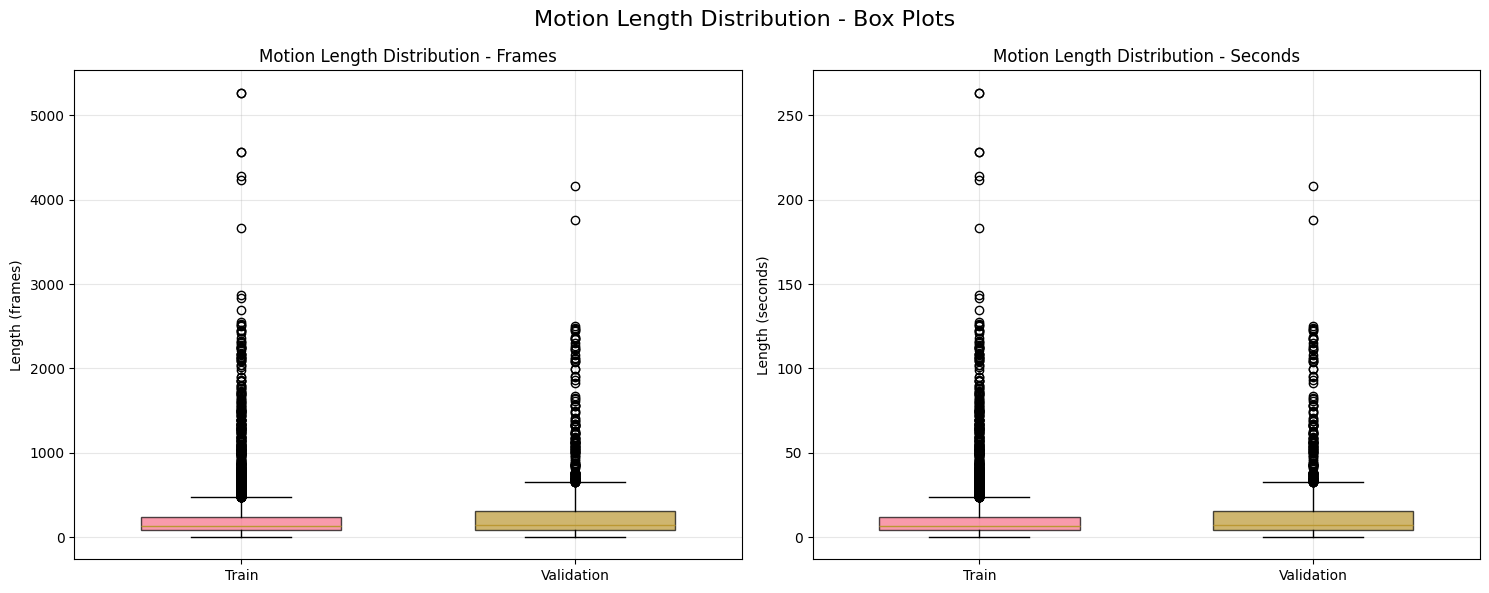

=== MOTION LENGTH FILTERING ANALYSIS ===

Train Dataset (6615 total motions):
  Motions < 2s: 304 (4.6%)
  Motions < 3s: 660 (10.0%)
  Motions < 5s: 2349 (35.5%)
  Motions > 10s: 1972 (29.8%)
  Motions > 15s: 1441 (21.8%)
  Motions > 20s: 1155 (17.5%)
  Motions > 25s: 838 (12.7%)
  Keeping 3s-15s: 4514 motions (68.2% retained)
  Keeping 3s-20s: 4800 motions (72.6% retained)
  Keeping 5s-20s: 3111 motions (47.0% retained)
--------------------------------------------------

Validation Dataset (2193 total motions):
  Motions < 2s: 85 (3.9%)
  Motions < 3s: 197 (9.0%)
  Motions < 5s: 720 (32.8%)
  Motions > 10s: 739 (33.7%)
  Motions > 15s: 561 (25.6%)
  Motions > 20s: 462 (21.1%)
  Motions > 25s: 338 (15.4%)
  Keeping 3s-15s: 1435 motions (65.4% retained)
  Keeping 3s-20s: 1534 motions (69.9% retained)
  Keeping 5s-20s: 1011 motions (46.1% retained)
--------------------------------------------------


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Motion Length Distribution - Box Plots', fontsize=16)

datasets = ['Train', 'Validation']
for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        box_data_frames = [lengths_frames]
        bp1 = axes[0].boxplot(box_data_frames, positions=[i+1], widths=0.6, patch_artist=True)
        bp1['boxes'][0].set_facecolor(f'C{i}')
        bp1['boxes'][0].set_alpha(0.7)
        
        box_data_seconds = [lengths_seconds]
        bp2 = axes[1].boxplot(box_data_seconds, positions=[i+1], widths=0.6, patch_artist=True)
        bp2['boxes'][0].set_facecolor(f'C{i}')
        bp2['boxes'][0].set_alpha(0.7)

axes[0].set_title('Motion Length Distribution - Frames')
axes[0].set_ylabel('Length (frames)')
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(datasets)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Motion Length Distribution - Seconds')
axes[1].set_ylabel('Length (seconds)')
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(datasets)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== MOTION LENGTH FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_seconds:
        total_motions = len(lengths_seconds)
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [2, 3, 5]:
            filtered_min = np.sum(np.array(lengths_seconds) < min_threshold)
            print(f"  Motions < {min_threshold}s: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [10, 15, 20, 25]:
            filtered_max = np.sum(np.array(lengths_seconds) > max_threshold)
            print(f"  Motions > {max_threshold}s: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(3, 15), (3, 20), (5, 20)]:
            filtered_both = np.sum((np.array(lengths_seconds) < min_t) | (np.array(lengths_seconds) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}s-{max_t}s: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Prompts per Motion Distribution**

This shows how many prompts are associated with each motion sequence, with horizontal lines indicating minimum, maximum, and average values.

</div>

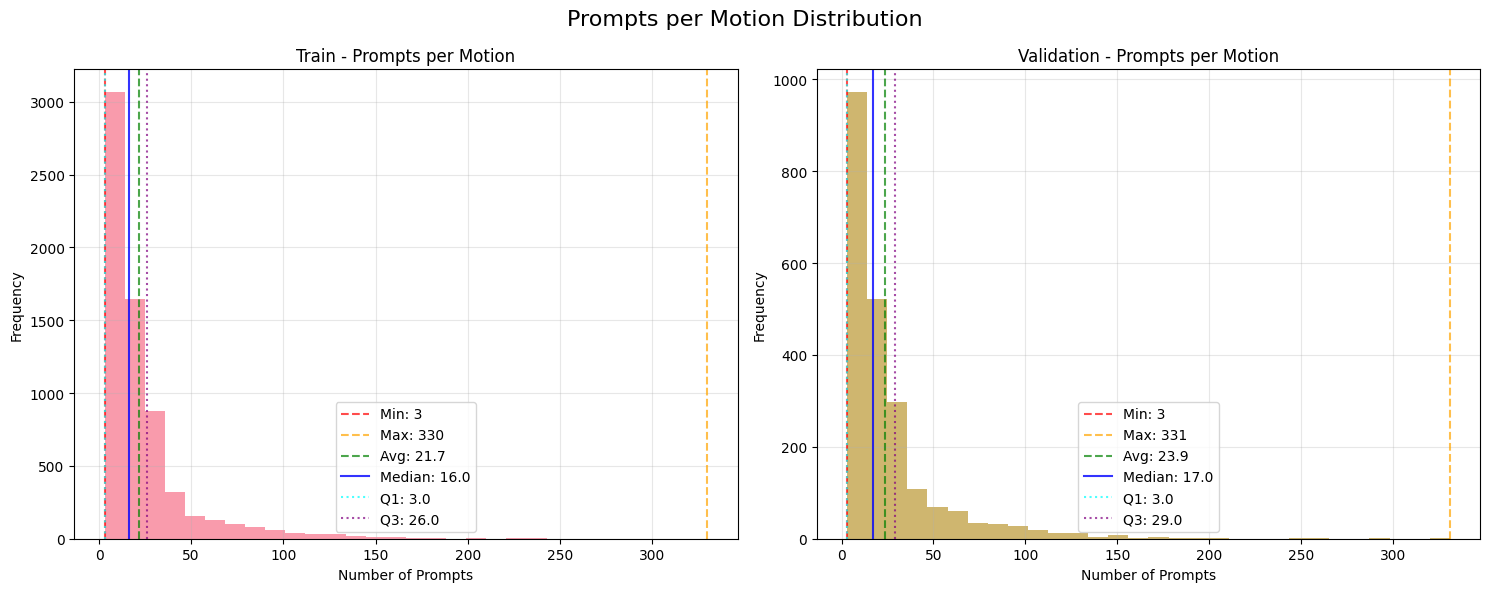

=== PROMPTS PER MOTION STATISTICS ===

Train Dataset:
  Min: 3, Mean: 21.67, Max: 330
  75th percentile: 26.00
  Data loss if filtering > 12 prompts: 3662 samples (55.4%)
  Data loss if filtering > 15 prompts: 3336 samples (50.4%)
  Data loss if filtering > 20 prompts: 2478 samples (37.5%)
--------------------------------------------------

Validation Dataset:
  Min: 3, Mean: 23.91, Max: 331
  75th percentile: 29.00
  Data loss if filtering > 12 prompts: 1249 samples (57.0%)
  Data loss if filtering > 15 prompts: 1147 samples (52.3%)
  Data loss if filtering > 20 prompts: 897 samples (40.9%)
--------------------------------------------------


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Prompts per Motion Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        axes[i].hist(prompts_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Prompts per Motion')
        axes[i].set_xlabel('Number of Prompts')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_prompts = np.min(prompts_per_motion)
        max_prompts = np.max(prompts_per_motion)
        avg_prompts = np.mean(prompts_per_motion)
        median_prompts = np.median(prompts_per_motion)
        q1_prompts = np.percentile(prompts_per_motion, 25)
        q3_prompts = np.percentile(prompts_per_motion, 75)
        
        axes[i].axvline(min_prompts, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_prompts}')
        axes[i].axvline(max_prompts, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_prompts}')
        axes[i].axvline(avg_prompts, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_prompts:.1f}')
        axes[i].axvline(median_prompts, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_prompts:.1f}')
        axes[i].axvline(q1_prompts, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_prompts:.1f}')
        axes[i].axvline(q3_prompts, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_prompts:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== PROMPTS PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(prompts_per_motion)}, Mean: {np.mean(prompts_per_motion):.2f}, Max: {np.max(prompts_per_motion)}")
        print(f"  75th percentile: {np.percentile(prompts_per_motion, 75):.2f}")
        
        for threshold in [12, 15, 20]:
            filtered_count = np.sum(np.array(prompts_per_motion) > threshold)
            loss_percentage = (filtered_count / len(prompts_per_motion)) * 100
            print(f"  Data loss if filtering > {threshold} prompts: {filtered_count} samples ({loss_percentage:.1f}%)")
    print("-" * 50)

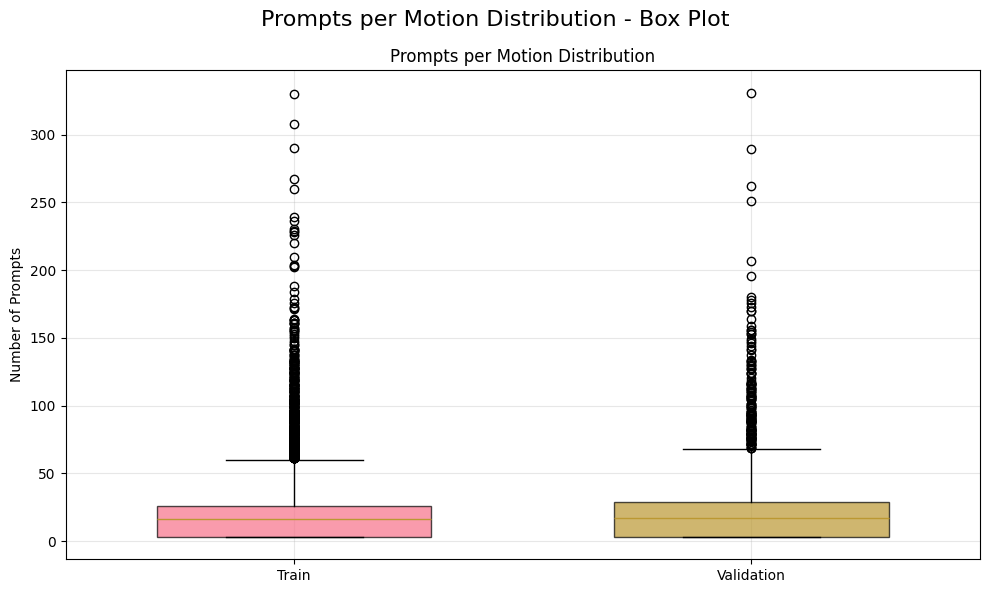

=== PROMPTS PER MOTION FILTERING ANALYSIS ===

Train Dataset (6615 total motions):
  Motions < 1 prompts: 0 (0.0%)
  Motions < 2 prompts: 0 (0.0%)
  Motions < 3 prompts: 0 (0.0%)
  Motions < 5 prompts: 2455 (37.1%)
  Motions > 8 prompts: 3955 (59.8%)
  Motions > 10 prompts: 3863 (58.4%)
  Motions > 12 prompts: 3662 (55.4%)
  Motions > 15 prompts: 3336 (50.4%)
  Motions > 20 prompts: 2478 (37.5%)
  Keeping 2-8 prompts: 2660 motions (40.2% retained)
  Keeping 2-10 prompts: 2752 motions (41.6% retained)
  Keeping 3-12 prompts: 2953 motions (44.6% retained)
--------------------------------------------------

Validation Dataset (2193 total motions):
  Motions < 1 prompts: 0 (0.0%)
  Motions < 2 prompts: 0 (0.0%)
  Motions < 3 prompts: 0 (0.0%)
  Motions < 5 prompts: 780 (35.6%)
  Motions > 8 prompts: 1341 (61.1%)
  Motions > 10 prompts: 1310 (59.7%)
  Motions > 12 prompts: 1249 (57.0%)
  Motions > 15 prompts: 1147 (52.3%)
  Motions > 20 prompts: 897 (40.9%)
  Keeping 2-8 prompts: 852 motion

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Prompts per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    prompts_per_motion = analysis['sample_prompt_counts']
    if prompts_per_motion:
        box_data.append(prompts_per_motion)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Prompts per Motion Distribution')
ax.set_ylabel('Number of Prompts')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== PROMPTS PER MOTION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        total_motions = len(prompts_per_motion)
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [1, 2, 3, 5]:
            filtered_min = np.sum(np.array(prompts_per_motion) < min_threshold)
            print(f"  Motions < {min_threshold} prompts: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [8, 10, 12, 15, 20]:
            filtered_max = np.sum(np.array(prompts_per_motion) > max_threshold)
            print(f"  Motions > {max_threshold} prompts: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(2, 8), (2, 10), (3, 12)]:
            filtered_both = np.sum((np.array(prompts_per_motion) < min_t) | (np.array(prompts_per_motion) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}-{max_t} prompts: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Spans per Motion Distribution**

This shows how many spans (temporal segments) are associated with each motion sequence, with horizontal lines indicating minimum, maximum, and average values.

</div>

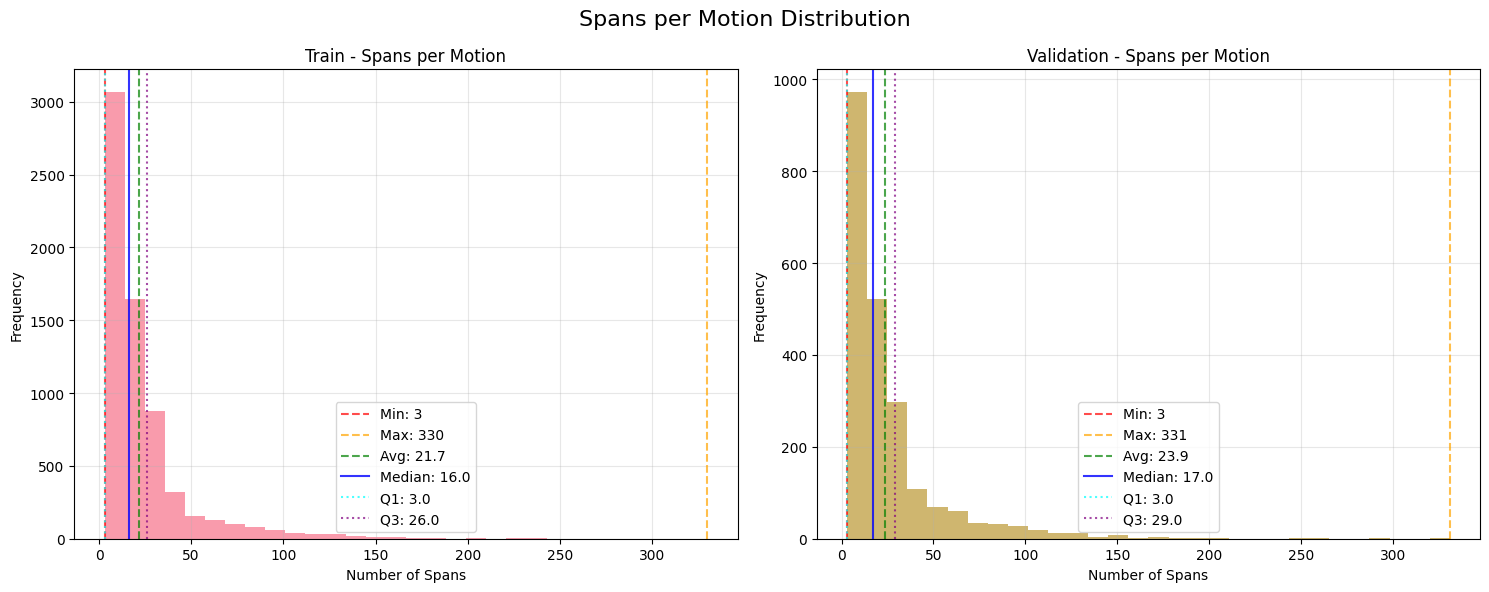

=== SPANS PER MOTION STATISTICS ===

Train Dataset:
  Min: 3, Mean: 21.67, Max: 330
  75th percentile: 26.00
  Data loss if filtering > 10 spans: 3863 samples (58.4%)
  Data loss if filtering > 15 spans: 3336 samples (50.4%)
  Data loss if filtering > 20 spans: 2478 samples (37.5%)
--------------------------------------------------

Validation Dataset:
  Min: 3, Mean: 23.91, Max: 331
  75th percentile: 29.00
  Data loss if filtering > 10 spans: 1310 samples (59.7%)
  Data loss if filtering > 15 spans: 1147 samples (52.3%)
  Data loss if filtering > 20 spans: 897 samples (40.9%)
--------------------------------------------------


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Spans per Motion Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        axes[i].hist(spans_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Spans per Motion')
        axes[i].set_xlabel('Number of Spans')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_spans = np.min(spans_per_motion)
        max_spans = np.max(spans_per_motion)
        avg_spans = np.mean(spans_per_motion)
        median_spans = np.median(spans_per_motion)
        q1_spans = np.percentile(spans_per_motion, 25)
        q3_spans = np.percentile(spans_per_motion, 75)
        
        axes[i].axvline(min_spans, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_spans}')
        axes[i].axvline(max_spans, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_spans}')
        axes[i].axvline(avg_spans, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_spans:.1f}')
        axes[i].axvline(median_spans, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_spans:.1f}')
        axes[i].axvline(q1_spans, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_spans:.1f}')
        axes[i].axvline(q3_spans, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_spans:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== SPANS PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(spans_per_motion)}, Mean: {np.mean(spans_per_motion):.2f}, Max: {np.max(spans_per_motion)}")
        print(f"  75th percentile: {np.percentile(spans_per_motion, 75):.2f}")
        
        for threshold in [10, 15, 20]:
            filtered_count = np.sum(np.array(spans_per_motion) > threshold)
            loss_percentage = (filtered_count / len(spans_per_motion)) * 100
            print(f"  Data loss if filtering > {threshold} spans: {filtered_count} samples ({loss_percentage:.1f}%)")
    print("-" * 50)

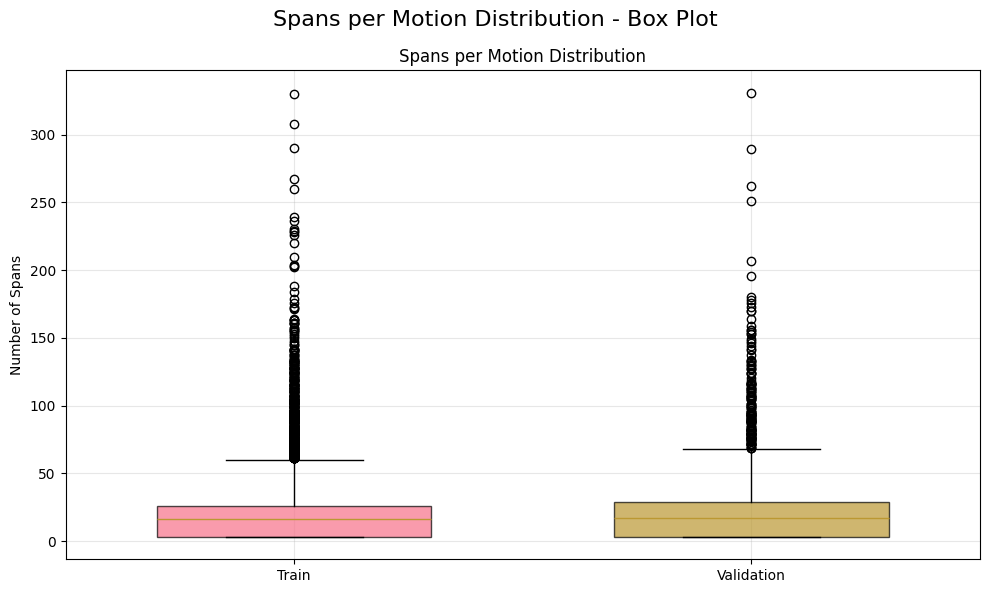

=== SPANS PER MOTION FILTERING ANALYSIS ===

Train Dataset (6615 total motions):
  Motions < 1 spans: 0 (0.0%)
  Motions < 2 spans: 0 (0.0%)
  Motions < 3 spans: 0 (0.0%)
  Motions < 5 spans: 2455 (37.1%)
  Motions > 8 spans: 3955 (59.8%)
  Motions > 10 spans: 3863 (58.4%)
  Motions > 12 spans: 3662 (55.4%)
  Motions > 15 spans: 3336 (50.4%)
  Motions > 20 spans: 2478 (37.5%)
  Keeping 2-8 spans: 2660 motions (40.2% retained)
  Keeping 2-10 spans: 2752 motions (41.6% retained)
  Keeping 3-12 spans: 2953 motions (44.6% retained)
--------------------------------------------------

Validation Dataset (2193 total motions):
  Motions < 1 spans: 0 (0.0%)
  Motions < 2 spans: 0 (0.0%)
  Motions < 3 spans: 0 (0.0%)
  Motions < 5 spans: 780 (35.6%)
  Motions > 8 spans: 1341 (61.1%)
  Motions > 10 spans: 1310 (59.7%)
  Motions > 12 spans: 1249 (57.0%)
  Motions > 15 spans: 1147 (52.3%)
  Motions > 20 spans: 897 (40.9%)
  Keeping 2-8 spans: 852 motions (38.9% retained)
  Keeping 2-10 spans: 883 m

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Spans per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    spans_per_motion = analysis['spans_per_motion']
    if spans_per_motion:
        box_data.append(spans_per_motion)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Spans per Motion Distribution')
ax.set_ylabel('Number of Spans')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== SPANS PER MOTION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        total_motions = len(spans_per_motion)
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [1, 2, 3, 5]:
            filtered_min = np.sum(np.array(spans_per_motion) < min_threshold)
            print(f"  Motions < {min_threshold} spans: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [8, 10, 12, 15, 20]:
            filtered_max = np.sum(np.array(spans_per_motion) > max_threshold)
            print(f"  Motions > {max_threshold} spans: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(2, 8), (2, 10), (3, 12)]:
            filtered_both = np.sum((np.array(spans_per_motion) < min_t) | (np.array(spans_per_motion) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}-{max_t} spans: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Spans Duration Distribution**

This shows the distribution of individual span durations in frames, with horizontal lines indicating minimum, maximum, and average values.

</div>

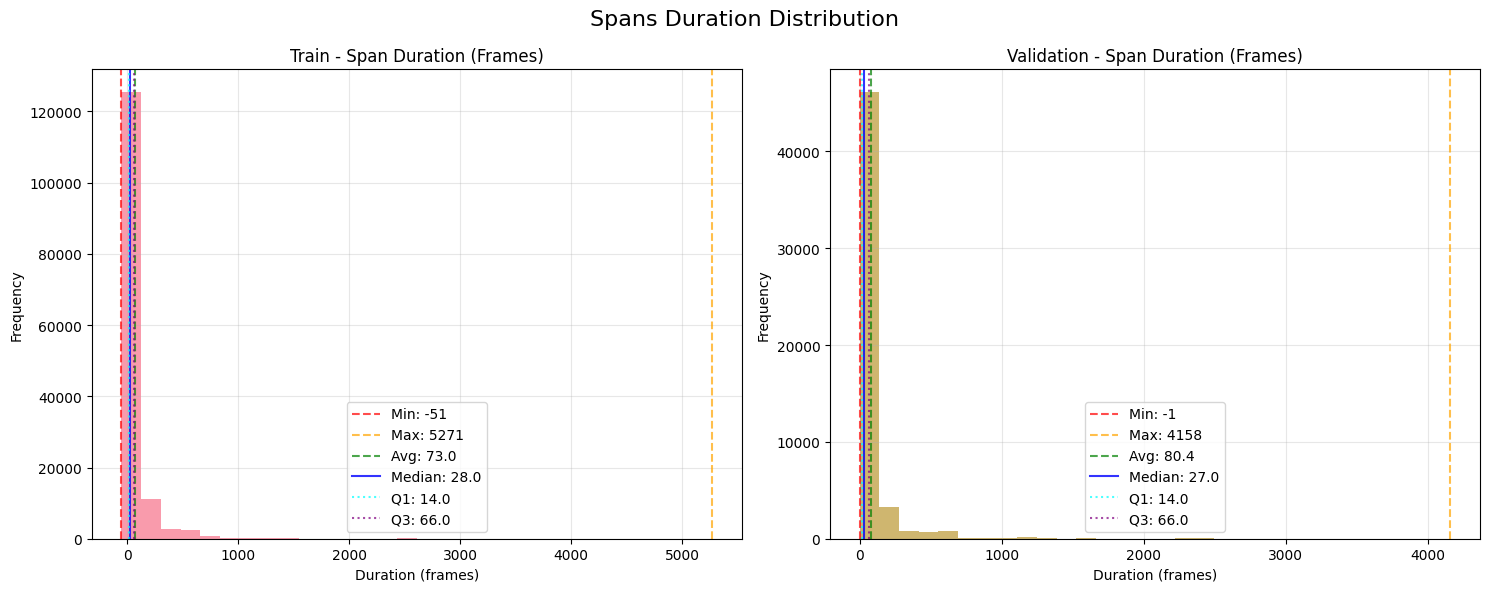

=== SPANS DURATION STATISTICS ===

Train Dataset:
  Min: -51 frames (-2.55s)
  Mean: 72.96 frames (3.65s)
  Max: 5271 frames (263.55s)
  75th percentile: 66.00 frames (3.30s)
  Data loss if filtering > 3s (60 frames): 38667 spans (27.0%)
  Data loss if filtering > 5s (100 frames): 23225 spans (16.2%)
  Data loss if filtering > 8s (160 frames): 13243 spans (9.2%)
--------------------------------------------------

Validation Dataset:
  Min: -1 frames (-0.05s)
  Mean: 80.35 frames (4.02s)
  Max: 4158 frames (207.90s)
  75th percentile: 66.00 frames (3.30s)
  Data loss if filtering > 3s (60 frames): 14151 spans (27.0%)
  Data loss if filtering > 5s (100 frames): 8786 spans (16.8%)
  Data loss if filtering > 8s (160 frames): 5223 spans (10.0%)
--------------------------------------------------


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Spans Duration Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        axes[i].hist(span_durations, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Span Duration (Frames)')
        axes[i].set_xlabel('Duration (frames)')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_duration = np.min(span_durations)
        max_duration = np.max(span_durations)
        avg_duration = np.mean(span_durations)
        median_duration = np.median(span_durations)
        q1_duration = np.percentile(span_durations, 25)
        q3_duration = np.percentile(span_durations, 75)
        
        axes[i].axvline(min_duration, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_duration}')
        axes[i].axvline(max_duration, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_duration}')
        axes[i].axvline(avg_duration, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_duration:.1f}')
        axes[i].axvline(median_duration, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_duration:.1f}')
        axes[i].axvline(q1_duration, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_duration:.1f}')
        axes[i].axvline(q3_duration, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_duration:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== SPANS DURATION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(span_durations)} frames ({np.min(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  Mean: {np.mean(span_durations):.2f} frames ({np.mean(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  Max: {np.max(span_durations)} frames ({np.max(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  75th percentile: {np.percentile(span_durations, 75):.2f} frames ({np.percentile(span_durations, 75)/DEFAULT_FPS:.2f}s)")
        
        for threshold_sec in [3, 5, 8]:
            threshold_frames = threshold_sec * DEFAULT_FPS
            filtered_count = np.sum(np.array(span_durations) > threshold_frames)
            loss_percentage = (filtered_count / len(span_durations)) * 100
            print(f"  Data loss if filtering > {threshold_sec}s ({threshold_frames} frames): {filtered_count} spans ({loss_percentage:.1f}%)")
    print("-" * 50)

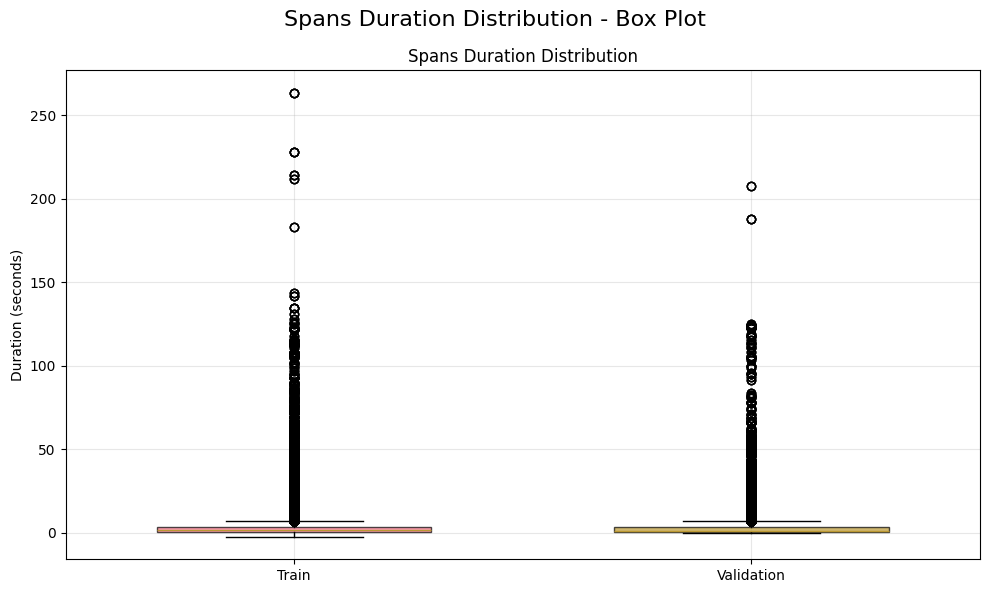

=== SPANS DURATION FILTERING ANALYSIS ===

Train Dataset (143365 total spans):
  Spans < 0.5s: 21242 (14.8%)
  Spans < 1.0s: 50731 (35.4%)
  Spans < 1.5s: 75012 (52.3%)
  Spans < 2.0s: 89084 (62.1%)
  Spans > 3s: 38667 (27.0%)
  Spans > 5s: 23225 (16.2%)
  Spans > 8s: 13243 (9.2%)
  Spans > 10s: 9710 (6.8%)
  Keeping 1.0s-5s: 69409 spans (48.4% retained)
  Keeping 1.0s-8s: 79391 spans (55.4% retained)
  Keeping 1.5s-8s: 55110 spans (38.4% retained)
--------------------------------------------------

Validation Dataset (52433 total spans):
  Spans < 0.5s: 8137 (15.5%)
  Spans < 1.0s: 19052 (36.3%)
  Spans < 1.5s: 27656 (52.7%)
  Spans < 2.0s: 32772 (62.5%)
  Spans > 3s: 14151 (27.0%)
  Spans > 5s: 8786 (16.8%)
  Spans > 8s: 5223 (10.0%)
  Spans > 10s: 3971 (7.6%)
  Keeping 1.0s-5s: 24595 spans (46.9% retained)
  Keeping 1.0s-8s: 28158 spans (53.7% retained)
  Keeping 1.5s-8s: 19554 spans (37.3% retained)
--------------------------------------------------


In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Spans Duration Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    span_durations = analysis['durations']
    if span_durations:
        span_durations_seconds = [d / DEFAULT_FPS for d in span_durations]
        box_data.append(span_durations_seconds)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Spans Duration Distribution')
ax.set_ylabel('Duration (seconds)')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== SPANS DURATION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        total_spans = len(span_durations)
        span_durations_seconds = [d / DEFAULT_FPS for d in span_durations]
        print(f"\n{name} Dataset ({total_spans} total spans):")
        
        for min_threshold in [0.5, 1.0, 1.5, 2.0]:
            filtered_min = np.sum(np.array(span_durations_seconds) < min_threshold)
            print(f"  Spans < {min_threshold}s: {filtered_min} ({filtered_min/total_spans*100:.1f}%)")
            
        for max_threshold in [3, 5, 8, 10]:
            filtered_max = np.sum(np.array(span_durations_seconds) > max_threshold)
            print(f"  Spans > {max_threshold}s: {filtered_max} ({filtered_max/total_spans*100:.1f}%)")
            
        for min_t, max_t in [(1.0, 5), (1.0, 8), (1.5, 8)]:
            filtered_both = np.sum((np.array(span_durations_seconds) < min_t) | (np.array(span_durations_seconds) > max_t))
            remaining = total_spans - filtered_both
            print(f"  Keeping {min_t}s-{max_t}s: {remaining} spans ({remaining/total_spans*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Total Spans per Motion (Per Motion Analysis)**

This shows the total span duration per motion sequence, indicating how much of each motion is covered by annotated spans.

</div>

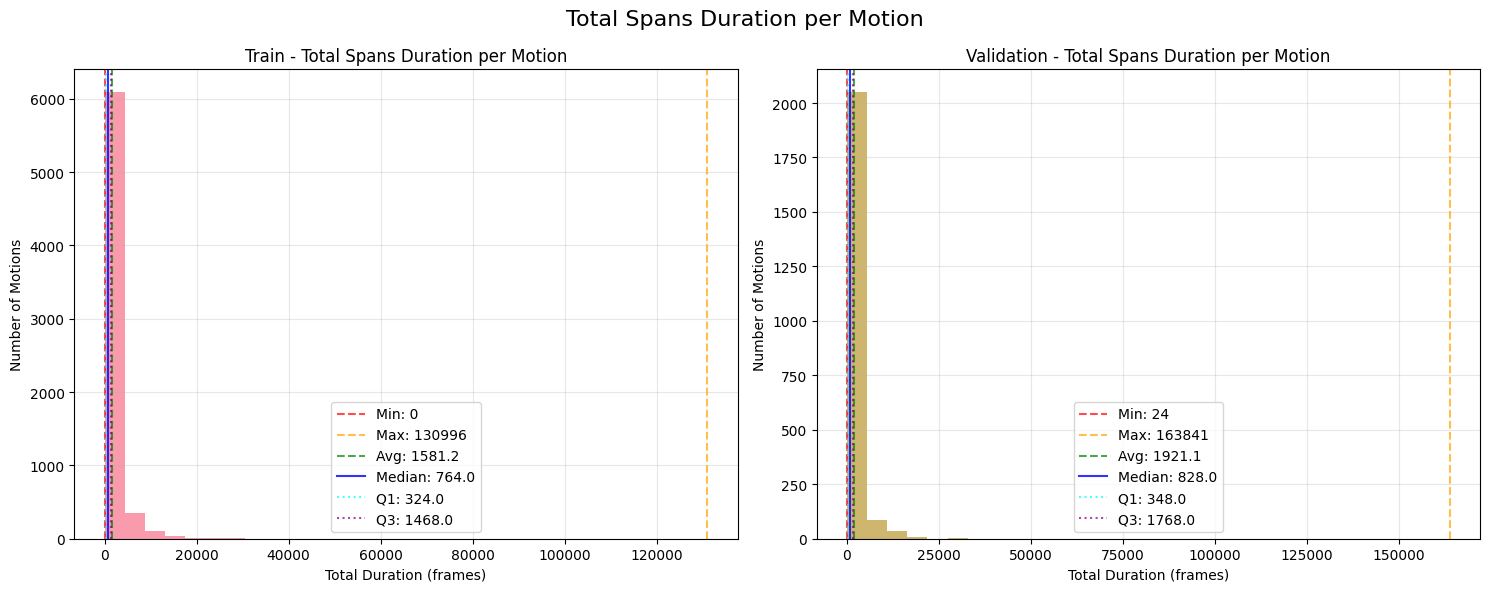

=== TOTAL SPANS DURATION PER MOTION STATISTICS ===

Train Dataset:
  Min: 0 frames (0.00s)
  Mean: 1581.18 frames (79.06s)
  Max: 130996 frames (6549.80s)
  75th percentile: 1468.00 frames (73.40s)
  Data loss if filtering > 10s total spans (200 frames): 5911 motions (89.4%)
  Data loss if filtering > 15s total spans (300 frames): 5094 motions (77.0%)
  Data loss if filtering > 20s total spans (400 frames): 4585 motions (69.3%)
--------------------------------------------------

Validation Dataset:
  Min: 24 frames (1.20s)
  Mean: 1921.12 frames (96.06s)
  Max: 163841 frames (8192.05s)
  75th percentile: 1768.00 frames (88.40s)
  Data loss if filtering > 10s total spans (200 frames): 1990 motions (90.7%)
  Data loss if filtering > 15s total spans (300 frames): 1720 motions (78.4%)
  Data loss if filtering > 20s total spans (400 frames): 1564 motions (71.3%)
--------------------------------------------------


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Total Spans Duration per Motion', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        axes[i].hist(spans_durations_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Total Spans Duration per Motion')
        axes[i].set_xlabel('Total Duration (frames)')
        axes[i].set_ylabel('Number of Motions')
        axes[i].grid(True, alpha=0.3)
        
        min_duration = np.min(spans_durations_per_motion)
        max_duration = np.max(spans_durations_per_motion)
        avg_duration = np.mean(spans_durations_per_motion)
        median_duration = np.median(spans_durations_per_motion)
        q1_duration = np.percentile(spans_durations_per_motion, 25)
        q3_duration = np.percentile(spans_durations_per_motion, 75)
        
        axes[i].axvline(min_duration, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_duration}')
        axes[i].axvline(max_duration, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_duration}')
        axes[i].axvline(avg_duration, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_duration:.1f}')
        axes[i].axvline(median_duration, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_duration:.1f}')
        axes[i].axvline(q1_duration, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_duration:.1f}')
        axes[i].axvline(q3_duration, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_duration:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== TOTAL SPANS DURATION PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(spans_durations_per_motion)} frames ({np.min(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  Mean: {np.mean(spans_durations_per_motion):.2f} frames ({np.mean(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  Max: {np.max(spans_durations_per_motion)} frames ({np.max(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  75th percentile: {np.percentile(spans_durations_per_motion, 75):.2f} frames ({np.percentile(spans_durations_per_motion, 75)/DEFAULT_FPS:.2f}s)")
        
        for threshold_sec in [10, 15, 20]:
            threshold_frames = threshold_sec * DEFAULT_FPS
            filtered_count = np.sum(np.array(spans_durations_per_motion) > threshold_frames)
            loss_percentage = (filtered_count / len(spans_durations_per_motion)) * 100
            print(f"  Data loss if filtering > {threshold_sec}s total spans ({threshold_frames} frames): {filtered_count} motions ({loss_percentage:.1f}%)")
    print("-" * 50)

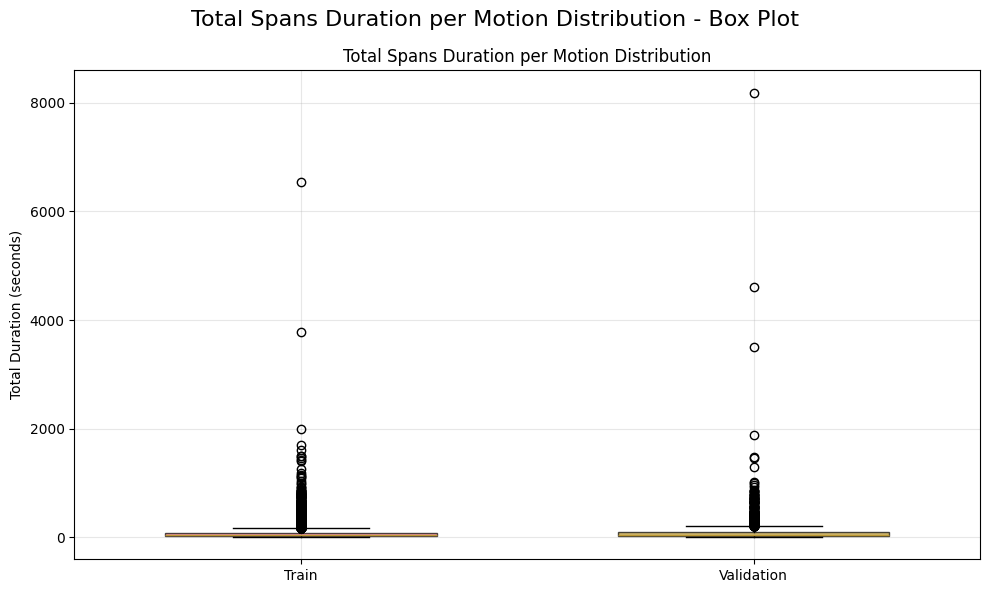

=== TOTAL SPANS DURATION PER MOTION FILTERING ANALYSIS ===

Train Dataset (6615 total motions):
  Motions < 2s total spans: 10 (0.2%)
  Motions < 3s total spans: 41 (0.6%)
  Motions < 5s total spans: 203 (3.1%)
  Motions > 10s total spans: 5911 (89.4%)
  Motions > 15s total spans: 5094 (77.0%)
  Motions > 20s total spans: 4585 (69.3%)
  Motions > 25s total spans: 4238 (64.1%)
  Keeping 3s-15s total spans: 1480 motions (22.4% retained)
  Keeping 3s-20s total spans: 1989 motions (30.1% retained)
  Keeping 5s-20s total spans: 1827 motions (27.6% retained)
--------------------------------------------------

Validation Dataset (2193 total motions):
  Motions < 2s total spans: 2 (0.1%)
  Motions < 3s total spans: 11 (0.5%)
  Motions < 5s total spans: 54 (2.5%)
  Motions > 10s total spans: 1990 (90.7%)
  Motions > 15s total spans: 1720 (78.4%)
  Motions > 20s total spans: 1564 (71.3%)
  Motions > 25s total spans: 1447 (66.0%)
  Keeping 3s-15s total spans: 462 motions (21.1% retained)
  Keepin

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Total Spans Duration per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    if spans_durations_per_motion:
        spans_durations_seconds = [d / DEFAULT_FPS for d in spans_durations_per_motion]
        box_data.append(spans_durations_seconds)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Total Spans Duration per Motion Distribution')
ax.set_ylabel('Total Duration (seconds)')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== TOTAL SPANS DURATION PER MOTION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        total_motions = len(spans_durations_per_motion)
        spans_durations_seconds = [d / DEFAULT_FPS for d in spans_durations_per_motion]
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [2, 3, 5]:
            filtered_min = np.sum(np.array(spans_durations_seconds) < min_threshold)
            print(f"  Motions < {min_threshold}s total spans: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [10, 15, 20, 25]:
            filtered_max = np.sum(np.array(spans_durations_seconds) > max_threshold)
            print(f"  Motions > {max_threshold}s total spans: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(3, 15), (3, 20), (5, 20)]:
            filtered_both = np.sum((np.array(spans_durations_seconds) < min_t) | (np.array(spans_durations_seconds) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}s-{max_t}s total spans: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)